In [1]:
import sys
# Find jVMC package
sys.path.append(sys.path[0] + "/..")

import jax
from jax.config import config
config.update("jax_enable_x64", True)

import jax.random as random
import jax.numpy as jnp
import flax.linen as nn

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# install the pip package and import jVMC
#!pip install jVMC

import jVMC

In [3]:
L = 10
g = -0.7

GPU_avail = False# True
# Initialize net
if GPU_avail:
  # reproduces results in Fig. 3 of the paper
  # estimated run_time in colab (GPU enabled): ~26 minutes
  net = jVMC.nets.CNN(F=(L,), channels=(16,), strides=(1,), periodicBoundary=True)
  n_steps = 1000
  n_Samples = 40000
else:
  # may be used to obtain results on Laptop CPUs
  # estimated run_time: ~100 seconds
  net = jVMC.nets.CpxRBM(numHidden=8, bias=False)
  n_steps = 300
  n_Samples = 5000

psi = jVMC.vqs.NQS(net, seed=1234)  # Variational wave function

In [4]:
def energy_single_p_mode(h_t, P):
    return np.sqrt(1 + h_t**2 - 2 * h_t * np.cos(P))

def ground_state_energy_per_site(h_t, N):
    Ps =  0.5 * np.arange(- (N - 1), N - 1 + 2, 2)
    Ps = Ps * 2 * np.pi / N
    energies_p_modes =  np.array([energy_single_p_mode(h_t, P) for P in Ps])
    return - 1 / N * np.sum(energies_p_modes)

exact_energy = ground_state_energy_per_site(g, L)
print(exact_energy)

-1.127222500154964


In [5]:
# Set up hamiltonian
hamiltonian = jVMC.operator.BranchFreeOperator()
for l in range(L):
    hamiltonian.add(jVMC.operator.scal_opstr(-1., (jVMC.operator.Sz(l), jVMC.operator.Sz((l + 1) % L))))
    hamiltonian.add(jVMC.operator.scal_opstr(g, (jVMC.operator.Sx(l), )))

In [7]:
# Set up sampler
sampler = jVMC.sampler.MCSampler(psi, (L,), random.PRNGKey(4321), updateProposer=jVMC.sampler.propose_spin_flip_Z2,
                                 numChains=100, sweepSteps=L,
                                 numSamples=n_Samples, thermalizationSweeps=25)

# Set up TDVP
#tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,
#                                   svdTol=1e-8, diagonalShift=10, makeReal='real')

tdvpEquation = jVMC.util.tdvp.TDVP(sampler, rhsPrefactor=1.,
                                   pinvTol=1e-8, diagonalShift=10, makeReal='real')

stepper = jVMC.util.stepper.Euler(timeStep=1e-2)  # ODE integrator

In [8]:
res = []
for n in range(n_steps):

    dp, _ = stepper.step(0, tdvpEquation, psi.get_parameters(), hamiltonian=hamiltonian, psi=psi, numSamples=None)
    psi.set_parameters(dp)

    print(n, jax.numpy.real(tdvpEquation.ElocMean0) / L, tdvpEquation.ElocVar0 / L)

    res.append([n, jax.numpy.real(tdvpEquation.ElocMean0) / L, tdvpEquation.ElocVar0 / L])

0 -0.7052768720248043 0.9814466904811834
1 -0.6980892042027035 1.0080819168328579
2 -0.7042029272195061 0.9543045950497829
3 -0.7245965419030096 1.012934394159066
4 -0.7190979027657128 0.9511813780930968
5 -0.7179727382825642 0.9962491744606545
6 -0.7190418572487228 0.9363669668116621
7 -0.7310251598029056 0.9615837038182857
8 -0.7327908186154733 0.9328770083369738
9 -0.7350561134104003 0.9588423451507087
10 -0.7425490421066304 0.9399395288889496
11 -0.746385967362175 0.903525155593786
12 -0.7477842476357676 0.920932262491261
13 -0.7493870019530988 0.9194494704632371
14 -0.7497468567196659 0.9006702049559958
15 -0.7566748086851784 0.8847846488487935
16 -0.7648266505432806 0.8808180499583134
17 -0.7714945545962087 0.8835963037587057
18 -0.7659006181478619 0.8880216049907486
19 -0.776140081887146 0.9002958675150957
20 -0.7822285754459634 0.8888076132806628
21 -0.7835620105018709 0.884745417988032
22 -0.7856711491629088 0.870662660711945
23 -0.7936685001431378 0.8672462164309443
24 -0.793

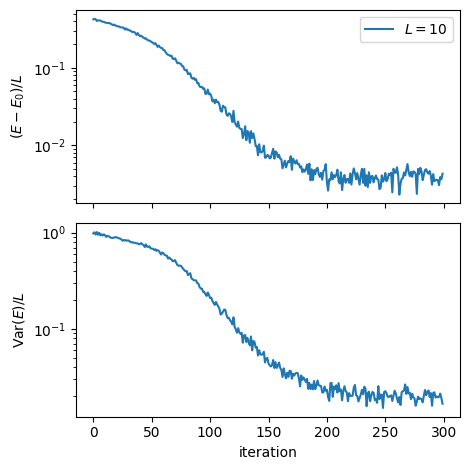

In [9]:
res = np.array(res)

fig, ax = plt.subplots(2,1, sharex=True, figsize=[4.8,4.8])
ax[0].semilogy(res[:, 0], res[:, 1] - exact_energy, '-', label=r"$L="+str(L)+"$")
ax[0].set_ylabel(r'$(E-E_0)/L$')

ax[1].semilogy(res[:, 0], res[:, 2], '-')
ax[1].set_ylabel(r'Var$(E)/L$')
ax[0].legend()
plt.xlabel('iteration')
plt.tight_layout()
plt.savefig('gs_search.pdf')